In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

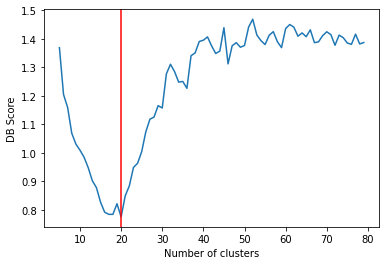

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

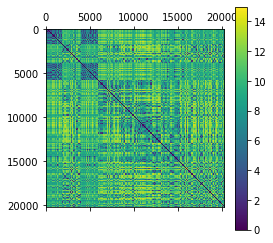

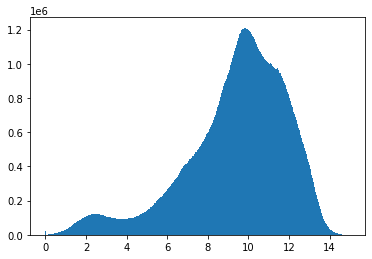

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

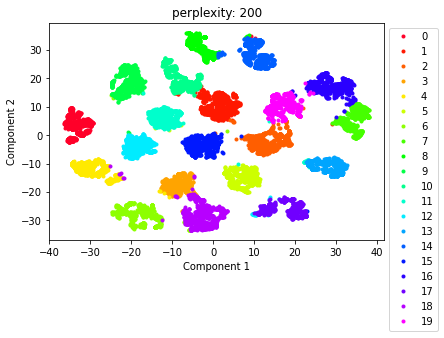

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9837382348593111


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.2851811647035315
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.7108080110497237
layer 6: 0.6180939226519337
layer 7: 0.448118093922652
layer 8: 0.25882683011049723
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.997 | Reg loss: 0.019 | Tree loss: 2.997 | Accuracy: 0.062000 | 1.396 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.989 | Reg loss: 0.018 | Tree loss: 2.989 | Accuracy: 0.062500 | 1.204 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.982 | Reg loss: 0.018 | Tree loss: 2.982 | Accuracy: 0.066500 | 1.188 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.979 | Reg loss: 0.018 | Tree loss: 2.979 | Accuracy: 0.062500 | 1.269 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.975 | Reg loss: 0.018 | Tree loss: 2.975 | Accuracy: 0.083500 | 1.411 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.967 | Reg loss: 0.017 | Tree loss: 2.967 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.953 | Reg loss: 0.016 | Tree loss: 2.953 | Accuracy: 0.191000 | 1.488 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.939 | Reg loss: 0.016 | Tree loss: 2.939 | Accuracy: 0.244500 | 1.49 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.926 | Reg loss: 0.016 | Tree loss: 2.926 | Accuracy: 0.226000 | 1.492 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.907 | Reg loss: 0.016 | Tree loss: 2.907 | Accuracy: 0.209500 | 1.489 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.886 | Reg loss: 0.016 | Tree loss: 2.886 | Accuracy: 0.214500 | 1.484 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.871 | Reg loss: 0.017 | Tree loss: 2.871 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 2.840 | Reg loss: 0.019 | Tree loss: 2.840 | Accuracy: 0.216500 | 1.485 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 2.802 | Reg loss: 0.019 | Tree loss: 2.802 | Accuracy: 0.209500 | 1.484 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 2.762 | Reg loss: 0.019 | Tree loss: 2.762 | Accuracy: 0.212000 | 1.481 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 2.715 | Reg loss: 0.019 | Tree loss: 2.715 | Accuracy: 0.225500 | 1.48 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.682 | Reg loss: 0.019 | Tree loss: 2.682 | Accuracy: 0.221500 | 1.48 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 2.648 | Reg loss: 0.019 | Tree loss: 2.648 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 2.638 | Reg loss: 0.022 | Tree loss: 2.638 | Accuracy: 0.223000 | 1.474 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 2.589 | Reg loss: 0.022 | Tree loss: 2.589 | Accuracy: 0.236000 | 1.471 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 2.557 | Reg loss: 0.022 | Tree loss: 2.557 | Accuracy: 0.226000 | 1.468 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 2.506 | Reg loss: 0.022 | Tree loss: 2.506 | Accuracy: 0.229500 | 1.466 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 2.468 | Reg loss: 0.022 | Tree loss: 2.468 | Accuracy: 0.234000 | 1.47 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.420 | Reg loss: 0.023 | Tree loss: 2.420 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 2.456 | Reg loss: 0.025 | Tree loss: 2.456 | Accuracy: 0.231500 | 1.453 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 2.412 | Reg loss: 0.025 | Tree loss: 2.412 | Accuracy: 0.241500 | 1.454 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 2.361 | Reg loss: 0.025 | Tree loss: 2.361 | Accuracy: 0.238000 | 1.454 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 2.324 | Reg loss: 0.025 | Tree loss: 2.324 | Accuracy: 0.254500 | 1.452 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 2.285 | Reg loss: 0.025 | Tree loss: 2.285 | Accuracy: 0.259000 | 1.452 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 2.245 | Reg loss: 0.026 | Tree loss: 2.245 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 2.320 | Reg loss: 0.028 | Tree loss: 2.320 | Accuracy: 0.230000 | 1.468 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 2.280 | Reg loss: 0.028 | Tree loss: 2.280 | Accuracy: 0.263500 | 1.468 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 2.196 | Reg loss: 0.028 | Tree loss: 2.196 | Accuracy: 0.287000 | 1.469 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 2.169 | Reg loss: 0.028 | Tree loss: 2.169 | Accuracy: 0.283000 | 1.467 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 2.101 | Reg loss: 0.028 | Tree loss: 2.101 | Accuracy: 0.324500 | 1.468 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 2.073 | Reg loss: 0.028 | Tree loss: 2.073 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 2.193 | Reg loss: 0.030 | Tree loss: 2.193 | Accuracy: 0.311500 | 1.521 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 2.138 | Reg loss: 0.030 | Tree loss: 2.138 | Accuracy: 0.314000 | 1.52 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 2.089 | Reg loss: 0.030 | Tree loss: 2.089 | Accuracy: 0.318500 | 1.519 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 2.039 | Reg loss: 0.030 | Tree loss: 2.039 | Accuracy: 0.336500 | 1.518 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 2.003 | Reg loss: 0.030 | Tree loss: 2.003 | Accuracy: 0.350500 | 1.517 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 1.933 | Reg loss: 0.030 | Tree loss: 1.933 | Ac

Epoch: 35 | Batch: 000 / 011 | Total loss: 2.107 | Reg loss: 0.031 | Tree loss: 2.107 | Accuracy: 0.339000 | 1.505 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 2.065 | Reg loss: 0.031 | Tree loss: 2.065 | Accuracy: 0.349500 | 1.504 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 2.004 | Reg loss: 0.032 | Tree loss: 2.004 | Accuracy: 0.378500 | 1.504 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 1.930 | Reg loss: 0.032 | Tree loss: 1.930 | Accuracy: 0.393500 | 1.504 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 1.875 | Reg loss: 0.032 | Tree loss: 1.875 | Accuracy: 0.401000 | 1.504 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 1.850 | Reg loss: 0.032 | Tree loss: 1.850 | Accuracy: 0.397500 | 1.504 sec/iter
Epoch: 35 | Batch: 006 / 011 | Total loss: 1.840 | Reg loss: 0.032 | Tree loss: 1.840 | Accuracy: 0.423500 | 1.504 sec/iter
Epoch: 35 | Batch: 007 / 011 | Total loss: 1.803 | Reg loss: 0.032 | Tree loss: 1.803 | Accuracy: 0.406500 | 1.504 sec/iter
Epoch: 3

Epoch: 40 | Batch: 000 / 011 | Total loss: 2.046 | Reg loss: 0.033 | Tree loss: 2.046 | Accuracy: 0.326000 | 1.5 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 1.994 | Reg loss: 0.033 | Tree loss: 1.994 | Accuracy: 0.354000 | 1.499 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 1.926 | Reg loss: 0.033 | Tree loss: 1.926 | Accuracy: 0.382500 | 1.499 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 1.883 | Reg loss: 0.033 | Tree loss: 1.883 | Accuracy: 0.390500 | 1.498 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 1.829 | Reg loss: 0.033 | Tree loss: 1.829 | Accuracy: 0.429500 | 1.499 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 1.787 | Reg loss: 0.033 | Tree loss: 1.787 | Accuracy: 0.432000 | 1.499 sec/iter
Epoch: 40 | Batch: 006 / 011 | Total loss: 1.755 | Reg loss: 0.033 | Tree loss: 1.755 | Accuracy: 0.436000 | 1.499 sec/iter
Epoch: 40 | Batch: 007 / 011 | Total loss: 1.748 | Reg loss: 0.033 | Tree loss: 1.748 | Accuracy: 0.441500 | 1.498 sec/iter
Epoch: 40 

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 1.979 | Reg loss: 0.034 | Tree loss: 1.979 | Accuracy: 0.323000 | 1.518 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 1.919 | Reg loss: 0.034 | Tree loss: 1.919 | Accuracy: 0.362500 | 1.518 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 1.888 | Reg loss: 0.034 | Tree loss: 1.888 | Accuracy: 0.376000 | 1.519 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 1.813 | Reg loss: 0.034 | Tree loss: 1.813 | Accuracy: 0.417500 | 1.519 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 1.782 | Reg loss: 0.034 | Tree loss: 1.782 | Accuracy: 0.436500 | 1.52 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 1.745 | Reg loss: 0.034 | Tree loss: 1.745 | Accuracy: 0.463000 | 1.521 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 1.713 | Reg loss: 0.034 | Tree loss: 1.713 | Accuracy: 0.425000 | 1.522 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 1.688 | Reg loss: 0.034 | Tree los

Epoch: 50 | Batch: 000 / 011 | Total loss: 1.906 | Reg loss: 0.034 | Tree loss: 1.906 | Accuracy: 0.347000 | 1.542 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 1.862 | Reg loss: 0.034 | Tree loss: 1.862 | Accuracy: 0.378000 | 1.542 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 1.838 | Reg loss: 0.034 | Tree loss: 1.838 | Accuracy: 0.398000 | 1.541 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.034 | Tree loss: 1.790 | Accuracy: 0.398000 | 1.54 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 1.739 | Reg loss: 0.034 | Tree loss: 1.739 | Accuracy: 0.423000 | 1.539 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 1.697 | Reg loss: 0.035 | Tree loss: 1.697 | Accuracy: 0.448500 | 1.538 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 1.668 | Reg loss: 0.035 | Tree loss: 1.668 | Accuracy: 0.458000 | 1.537 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 1.661 | Reg loss: 0.035 | Tree loss: 1.661 | Accuracy: 0.431000 | 1.537 sec/iter
Epoch: 50

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 1.876 | Reg loss: 0.035 | Tree loss: 1.876 | Accuracy: 0.367000 | 1.553 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 1.845 | Reg loss: 0.035 | Tree loss: 1.845 | Accuracy: 0.361000 | 1.553 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 1.790 | Reg loss: 0.035 | Tree loss: 1.790 | Accuracy: 0.396500 | 1.553 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 1.748 | Reg loss: 0.035 | Tree loss: 1.748 | Accuracy: 0.431500 | 1.553 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 1.697 | Reg loss: 0.035 | Tree loss: 1.697 | Accuracy: 0.443000 | 1.553 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 1.677 | Reg loss: 0.035 | Tree loss: 1.677 | Accuracy: 0.445500 | 1.553 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 1.621 | Reg loss: 0.035 | Tree loss: 1.621 | Accuracy: 0.474000 | 1.553 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 1.607 | Reg loss: 0.035 | Tree lo

layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 1.844 | Reg loss: 0.036 | Tree loss: 1.844 | Accuracy: 0.350000 | 1.567 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 1.814 | Reg loss: 0.036 | Tree loss: 1.814 | Accuracy: 0.350000 | 1.567 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 1.743 | Reg loss: 0.036 | Tree loss: 1.743 | Accuracy: 0.418500 | 1.567 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 1.703 | Reg loss: 0.036 | Tree loss: 1.703 | Accuracy: 0.441500 | 1.567 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 1.650 | Reg loss: 0.036 | Tree loss: 1.650 | Accuracy: 0.470000 | 1.567 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 1.633 | Reg loss: 0.036 | Tree loss: 1.633 | Accuracy: 0.461000 | 1.566 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 1.611 | Reg loss: 0.036 | Tree loss: 1.611 | Accuracy: 0.460500 | 1.566 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 1.586 | Reg loss: 0.036 | Tree loss: 1.586 | Accuracy: 0.4560

Epoch: 65 | Batch: 000 / 011 | Total loss: 1.812 | Reg loss: 0.036 | Tree loss: 1.812 | Accuracy: 0.376500 | 1.579 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 1.774 | Reg loss: 0.036 | Tree loss: 1.774 | Accuracy: 0.372500 | 1.579 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 1.729 | Reg loss: 0.036 | Tree loss: 1.729 | Accuracy: 0.422500 | 1.578 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.688 | Reg loss: 0.036 | Tree loss: 1.688 | Accuracy: 0.453000 | 1.577 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 1.647 | Reg loss: 0.036 | Tree loss: 1.647 | Accuracy: 0.452000 | 1.576 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 1.607 | Reg loss: 0.036 | Tree loss: 1.607 | Accuracy: 0.468000 | 1.576 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 1.583 | Reg loss: 0.036 | Tree loss: 1.583 | Accuracy: 0.467500 | 1.575 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 1.591 | Reg loss: 0.036 | Tree loss: 1.591 | Accuracy: 0.437000 | 1.575 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 1.758 | Reg loss: 0.036 | Tree loss: 1.758 | Accuracy: 0.409500 | 1.594 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 1.738 | Reg loss: 0.036 | Tree loss: 1.738 | Accuracy: 0.401500 | 1.594 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 1.690 | Reg loss: 0.036 | Tree loss: 1.690 | Accuracy: 0.444000 | 1.594 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 1.638 | Reg loss: 0.036 | Tree loss: 1.638 | Accuracy: 0.460000 | 1.593 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 1.616 | Reg loss: 0.036 | Tree loss: 1.616 | Accuracy: 0.477000 | 1.593 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 1.587 | Reg loss: 0.036 | Tree loss: 1.587 | Accuracy: 0.454500 | 1.593 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 1.581 | Reg loss: 0.036 | Tree loss: 1.581 | Accuracy: 0.448000 | 1.593 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 1.554 | Reg loss: 0.036 | Tree loss: 1.554 | Accuracy: 0.461000 | 1.593 sec/iter
Epoch: 7

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 1.765 | Reg loss: 0.037 | Tree loss: 1.765 | Accuracy: 0.382500 | 1.606 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 1.718 | Reg loss: 0.037 | Tree loss: 1.718 | Accuracy: 0.403500 | 1.606 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 1.663 | Reg loss: 0.037 | Tree loss: 1.663 | Accuracy: 0.424500 | 1.605 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 1.602 | Reg loss: 0.037 | Tree loss: 1.602 | Accuracy: 0.466500 | 1.605 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 1.589 | Reg loss: 0.037 | Tree loss: 1.589 | Accuracy: 0.473000 | 1.605 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 1.571 | Reg loss: 0.037 | Tree loss: 1.571 | Accuracy: 0.473500 | 1.605 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 1.521 | Reg loss: 0.037 | Tree loss: 1.521 | Accuracy: 0.489500 | 1.604 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 1.529 | Reg loss: 0.037 | Tree lo

Epoch: 80 | Batch: 000 / 011 | Total loss: 1.753 | Reg loss: 0.037 | Tree loss: 1.753 | Accuracy: 0.372500 | 1.609 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 1.706 | Reg loss: 0.037 | Tree loss: 1.706 | Accuracy: 0.389000 | 1.608 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 1.634 | Reg loss: 0.037 | Tree loss: 1.634 | Accuracy: 0.439000 | 1.608 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 1.622 | Reg loss: 0.037 | Tree loss: 1.622 | Accuracy: 0.448500 | 1.607 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 1.583 | Reg loss: 0.037 | Tree loss: 1.583 | Accuracy: 0.469000 | 1.606 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 1.550 | Reg loss: 0.037 | Tree loss: 1.550 | Accuracy: 0.481500 | 1.606 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 1.516 | Reg loss: 0.037 | Tree loss: 1.516 | Accuracy: 0.490500 | 1.605 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 1.518 | Reg loss: 0.037 | Tree loss: 1.518 | Accuracy: 0.476000 | 1.605 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 1.696 | Reg loss: 0.037 | Tree loss: 1.696 | Accuracy: 0.396000 | 1.619 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 1.676 | Reg loss: 0.037 | Tree loss: 1.676 | Accuracy: 0.392500 | 1.619 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 1.634 | Reg loss: 0.037 | Tree loss: 1.634 | Accuracy: 0.427500 | 1.619 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.623 | Reg loss: 0.037 | Tree loss: 1.623 | Accuracy: 0.435000 | 1.618 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 1.558 | Reg loss: 0.037 | Tree loss: 1.558 | Accuracy: 0.485500 | 1.618 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 1.534 | Reg loss: 0.037 | Tree loss: 1.534 | Accuracy: 0.493000 | 1.618 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 1.526 | Reg loss: 0.037 | Tree loss: 1.526 | Accuracy: 0.469000 | 1.618 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 1.511 | Reg loss: 0.037 | Tree loss: 1.511 | Accuracy: 0.468500 | 1.618 sec/iter
Epoch: 8

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 1.693 | Reg loss: 0.037 | Tree loss: 1.693 | Accuracy: 0.385500 | 1.628 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 1.659 | Reg loss: 0.037 | Tree loss: 1.659 | Accuracy: 0.403000 | 1.627 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 1.642 | Reg loss: 0.037 | Tree loss: 1.642 | Accuracy: 0.406500 | 1.627 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.591 | Reg loss: 0.037 | Tree loss: 1.591 | Accuracy: 0.468500 | 1.627 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 1.542 | Reg loss: 0.037 | Tree loss: 1.542 | Accuracy: 0.458500 | 1.626 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 1.519 | Reg loss: 0.037 | Tree loss: 1.519 | Accuracy: 0.477000 | 1.626 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 1.542 | Reg loss: 0.037 | Tree loss: 1.542 | Accuracy: 0.466500 | 1.626 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 1.489 | Reg loss: 0.037 | Tree lo

Epoch: 95 | Batch: 000 / 011 | Total loss: 1.712 | Reg loss: 0.037 | Tree loss: 1.712 | Accuracy: 0.378000 | 1.63 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 1.665 | Reg loss: 0.037 | Tree loss: 1.665 | Accuracy: 0.392000 | 1.629 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 1.627 | Reg loss: 0.037 | Tree loss: 1.627 | Accuracy: 0.430500 | 1.628 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 1.607 | Reg loss: 0.037 | Tree loss: 1.607 | Accuracy: 0.445000 | 1.628 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 1.553 | Reg loss: 0.037 | Tree loss: 1.553 | Accuracy: 0.483000 | 1.627 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 1.501 | Reg loss: 0.037 | Tree loss: 1.501 | Accuracy: 0.486500 | 1.627 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 1.485 | Reg loss: 0.037 | Tree loss: 1.485 | Accuracy: 0.488500 | 1.626 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 1.490 | Reg loss: 0.037 | Tree loss: 1.490 | Accuracy: 0.469000 | 1.626 sec/iter
Epoch: 95

Epoch: 100 | Batch: 000 / 011 | Total loss: 1.692 | Reg loss: 0.037 | Tree loss: 1.692 | Accuracy: 0.395000 | 1.637 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 1.661 | Reg loss: 0.037 | Tree loss: 1.661 | Accuracy: 0.398000 | 1.637 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 1.607 | Reg loss: 0.038 | Tree loss: 1.607 | Accuracy: 0.430500 | 1.637 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 1.579 | Reg loss: 0.038 | Tree loss: 1.579 | Accuracy: 0.437500 | 1.637 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 1.538 | Reg loss: 0.038 | Tree loss: 1.538 | Accuracy: 0.459000 | 1.637 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 1.540 | Reg loss: 0.038 | Tree loss: 1.540 | Accuracy: 0.465500 | 1.637 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 1.487 | Reg loss: 0.038 | Tree loss: 1.487 | Accuracy: 0.480000 | 1.636 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 1.471 | Reg loss: 0.038 | Tree loss: 1.471 | Accuracy: 0.477000 | 1.636 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 1.674 | Reg loss: 0.038 | Tree loss: 1.674 | Accuracy: 0.379500 | 1.642 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 1.627 | Reg loss: 0.038 | Tree loss: 1.627 | Accuracy: 0.407000 | 1.642 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 1.604 | Reg loss: 0.038 | Tree loss: 1.604 | Accuracy: 0.419500 | 1.642 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 1.546 | Reg loss: 0.038 | Tree loss: 1.546 | Accuracy: 0.458000 | 1.642 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 1.552 | Reg loss: 0.038 | Tree loss: 1.552 | Accuracy: 0.459500 | 1.641 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 1.503 | Reg loss: 0.038 | Tree loss: 1.503 | Accuracy: 0.474500 | 1.641 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 1.508 | Reg loss: 0.038 | Tree loss: 1.508 | Accuracy: 0.491000 | 1.641 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total los

Epoch: 110 | Batch: 000 / 011 | Total loss: 1.688 | Reg loss: 0.038 | Tree loss: 1.688 | Accuracy: 0.386500 | 1.645 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.635 | Reg loss: 0.038 | Tree loss: 1.635 | Accuracy: 0.386000 | 1.644 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 1.593 | Reg loss: 0.038 | Tree loss: 1.593 | Accuracy: 0.442000 | 1.644 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.544 | Reg loss: 0.038 | Tree loss: 1.544 | Accuracy: 0.462500 | 1.643 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 1.521 | Reg loss: 0.038 | Tree loss: 1.521 | Accuracy: 0.476500 | 1.643 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 1.498 | Reg loss: 0.038 | Tree loss: 1.498 | Accuracy: 0.487000 | 1.642 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 1.476 | Reg loss: 0.038 | Tree loss: 1.476 | Accuracy: 0.468000 | 1.642 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 1.470 | Reg loss: 0.038 | Tree loss: 1.470 | Accuracy: 0.487000 | 1.641 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 1.656 | Reg loss: 0.038 | Tree loss: 1.656 | Accuracy: 0.391000 | 1.651 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.635 | Reg loss: 0.038 | Tree loss: 1.635 | Accuracy: 0.415500 | 1.651 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.588 | Reg loss: 0.038 | Tree loss: 1.588 | Accuracy: 0.438000 | 1.65 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 1.556 | Reg loss: 0.038 | Tree loss: 1.556 | Accuracy: 0.453500 | 1.65 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 1.519 | Reg loss: 0.038 | Tree loss: 1.519 | Accuracy: 0.477500 | 1.65 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 1.501 | Reg loss: 0.038 | Tree loss: 1.501 | Accuracy: 0.489500 | 1.65 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 1.486 | Reg loss: 0.038 | Tree loss: 1.486 | Accuracy: 0.478500 | 1.65 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 1.483 | Reg loss: 0.038 | Tree

layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 1.688 | Reg loss: 0.038 | Tree loss: 1.688 | Accuracy: 0.368500 | 1.656 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.619 | Reg loss: 0.038 | Tree loss: 1.619 | Accuracy: 0.416000 | 1.655 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 1.589 | Reg loss: 0.038 | Tree loss: 1.589 | Accuracy: 0.425000 | 1.655 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 1.547 | Reg loss: 0.038 | Tree loss: 1.547 | Accuracy: 0.457000 | 1.655 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 1.513 | Reg loss: 0.038 | Tree loss: 1.513 | Accuracy: 0.463000 | 1.655 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 1.479 | Reg loss: 0.038 | Tree loss: 1.479 | Accuracy: 0.486000 | 1.655 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 1.447 | Reg loss: 0.038 | Tree loss: 1.447 | Accuracy: 0.498500 | 1.654 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 1.466 | Reg loss: 0.038 | Tree loss: 1.466 | Accuracy

Epoch: 125 | Batch: 000 / 011 | Total loss: 1.662 | Reg loss: 0.038 | Tree loss: 1.662 | Accuracy: 0.378000 | 1.654 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 1.652 | Reg loss: 0.038 | Tree loss: 1.652 | Accuracy: 0.392000 | 1.653 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 1.601 | Reg loss: 0.038 | Tree loss: 1.601 | Accuracy: 0.415000 | 1.653 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 1.549 | Reg loss: 0.038 | Tree loss: 1.549 | Accuracy: 0.449500 | 1.653 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 1.496 | Reg loss: 0.038 | Tree loss: 1.496 | Accuracy: 0.486000 | 1.653 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 1.475 | Reg loss: 0.038 | Tree loss: 1.475 | Accuracy: 0.490500 | 1.653 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 1.448 | Reg loss: 0.038 | Tree loss: 1.448 | Accuracy: 0.483500 | 1.653 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 1.463 | Reg loss: 0.038 | Tree loss: 1.463 | Accuracy: 0.472000 | 1.652 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 1.630 | Reg loss: 0.038 | Tree loss: 1.630 | Accuracy: 0.399000 | 1.65 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 1.618 | Reg loss: 0.038 | Tree loss: 1.618 | Accuracy: 0.415500 | 1.65 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 1.589 | Reg loss: 0.038 | Tree loss: 1.589 | Accuracy: 0.414500 | 1.65 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 1.567 | Reg loss: 0.038 | Tree loss: 1.567 | Accuracy: 0.436500 | 1.65 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 1.475 | Reg loss: 0.038 | Tree loss: 1.475 | Accuracy: 0.488500 | 1.649 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 1.473 | Reg loss: 0.038 | Tree loss: 1.473 | Accuracy: 0.480000 | 1.649 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 1.471 | Reg loss: 0.038 | Tree loss: 1.471 | Accuracy: 0.476500 | 1.649 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 1.465 | Reg loss: 0.038 | Tree loss: 1.465 | Accuracy: 0.473500 | 1.649 sec/iter
Epoc

Epoch: 135 | Batch: 000 / 011 | Total loss: 1.649 | Reg loss: 0.038 | Tree loss: 1.649 | Accuracy: 0.393000 | 1.648 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 1.610 | Reg loss: 0.038 | Tree loss: 1.610 | Accuracy: 0.403500 | 1.648 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 1.591 | Reg loss: 0.038 | Tree loss: 1.591 | Accuracy: 0.422000 | 1.648 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 1.536 | Reg loss: 0.038 | Tree loss: 1.536 | Accuracy: 0.441500 | 1.648 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 1.509 | Reg loss: 0.038 | Tree loss: 1.509 | Accuracy: 0.475000 | 1.648 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 1.483 | Reg loss: 0.038 | Tree loss: 1.483 | Accuracy: 0.487500 | 1.648 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 1.454 | Reg loss: 0.038 | Tree loss: 1.454 | Accuracy: 0.495500 | 1.647 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 1.447 | Reg loss: 0.038 | Tree loss: 1.447 | Accuracy: 0.483500 | 1.647 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 1.629 | Reg loss: 0.038 | Tree loss: 1.629 | Accuracy: 0.414500 | 1.642 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 1.597 | Reg loss: 0.038 | Tree loss: 1.597 | Accuracy: 0.404500 | 1.642 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 1.593 | Reg loss: 0.038 | Tree loss: 1.593 | Accuracy: 0.429500 | 1.642 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 1.525 | Reg loss: 0.038 | Tree loss: 1.525 | Accuracy: 0.469000 | 1.642 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 1.517 | Reg loss: 0.038 | Tree loss: 1.517 | Accuracy: 0.456500 | 1.642 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 1.474 | Reg loss: 0.038 | Tree loss: 1.474 | Accuracy: 0.485500 | 1.641 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 1.461 | Reg loss: 0.038 | Tree loss: 1.461 | Accuracy: 0.486000 | 1.641 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 1.459 | Reg loss: 0.039 | Tree loss: 1.459 | Accuracy: 0.466000 | 1.641 sec/iter


Epoch: 145 | Batch: 000 / 011 | Total loss: 1.646 | Reg loss: 0.039 | Tree loss: 1.646 | Accuracy: 0.394500 | 1.654 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 1.617 | Reg loss: 0.039 | Tree loss: 1.617 | Accuracy: 0.399500 | 1.654 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 1.574 | Reg loss: 0.039 | Tree loss: 1.574 | Accuracy: 0.403500 | 1.654 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 1.538 | Reg loss: 0.039 | Tree loss: 1.538 | Accuracy: 0.447500 | 1.654 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 1.495 | Reg loss: 0.039 | Tree loss: 1.495 | Accuracy: 0.467000 | 1.654 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 1.487 | Reg loss: 0.039 | Tree loss: 1.487 | Accuracy: 0.496000 | 1.654 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 1.447 | Reg loss: 0.039 | Tree loss: 1.447 | Accuracy: 0.488500 | 1.654 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 1.434 | Reg loss: 0.039 | Tree loss: 1.434 | Accuracy: 0.500500 | 1.654 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 1.631 | Reg loss: 0.039 | Tree loss: 1.631 | Accuracy: 0.397500 | 1.667 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 1.600 | Reg loss: 0.039 | Tree loss: 1.600 | Accuracy: 0.404000 | 1.667 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 1.565 | Reg loss: 0.039 | Tree loss: 1.565 | Accuracy: 0.414000 | 1.667 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 1.531 | Reg loss: 0.039 | Tree loss: 1.531 | Accuracy: 0.468000 | 1.667 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 1.491 | Reg loss: 0.039 | Tree loss: 1.491 | Accuracy: 0.471000 | 1.667 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 1.468 | Reg loss: 0.039 | Tree loss: 1.468 | Accuracy: 0.477500 | 1.667 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 1.463 | Reg loss: 0.039 | Tree loss: 1.463 | Accuracy: 0.473000 | 1.667 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.039 | Tree loss: 1.433 | Accuracy: 0.495000 | 1.668 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 1.654 | Reg loss: 0.039 | Tree loss: 1.654 | Accuracy: 0.374500 | 1.676 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 1.595 | Reg loss: 0.039 | Tree loss: 1.595 | Accuracy: 0.429000 | 1.676 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 1.552 | Reg loss: 0.039 | Tree loss: 1.552 | Accuracy: 0.456000 | 1.676 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 1.529 | Reg loss: 0.039 | Tree loss: 1.529 | Accuracy: 0.473000 | 1.676 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 1.517 | Reg loss: 0.039 | Tree loss: 1.517 | Accuracy: 0.481000 | 1.676 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 1.479 | Reg loss: 0.039 | Tree loss: 1.479 | Accuracy: 0.487500 | 1.675 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 1.424 | Reg loss: 0.039 | Tree loss: 1.424 | Accuracy: 0.503500 | 1.675 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 1.452 | Reg loss: 0.039 | Tree loss: 1.452 | Accuracy: 0.482000 | 1.675 sec/iter


Epoch: 160 | Batch: 000 / 011 | Total loss: 1.632 | Reg loss: 0.039 | Tree loss: 1.632 | Accuracy: 0.412000 | 1.673 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 1.613 | Reg loss: 0.039 | Tree loss: 1.613 | Accuracy: 0.410500 | 1.673 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 1.596 | Reg loss: 0.039 | Tree loss: 1.596 | Accuracy: 0.420500 | 1.673 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 1.559 | Reg loss: 0.039 | Tree loss: 1.559 | Accuracy: 0.419500 | 1.673 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 1.465 | Reg loss: 0.039 | Tree loss: 1.465 | Accuracy: 0.499500 | 1.673 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 1.458 | Reg loss: 0.039 | Tree loss: 1.458 | Accuracy: 0.489000 | 1.673 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 1.433 | Reg loss: 0.039 | Tree loss: 1.433 | Accuracy: 0.505000 | 1.672 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 1.464 | Reg loss: 0.039 | Tree loss: 1.464 | Accuracy: 0.463500 | 1.672 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 165 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.039 | Tree loss: 1.616 | Accuracy: 0.397500 | 1.675 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 1.603 | Reg loss: 0.039 | Tree loss: 1.603 | Accuracy: 0.407500 | 1.675 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 1.573 | Reg loss: 0.039 | Tree loss: 1.573 | Accuracy: 0.422000 | 1.675 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 1.525 | Reg loss: 0.039 | Tree loss: 1.525 | Accuracy: 0.466000 | 1.675 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 1.480 | Reg loss: 0.039 | Tree loss: 1.480 | Accuracy: 0.490000 | 1.675 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 1.450 | Reg loss: 0.039 | Tree loss: 1.450 | Accuracy: 0.500500 | 1.675 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 1.468 | Reg loss: 0.039 | Tree loss: 1.468 | Accuracy: 0.491500 | 1.674 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total los

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 170 | Batch: 000 / 011 | Total loss: 1.651 | Reg loss: 0.039 | Tree loss: 1.651 | Accuracy: 0.400500 | 1.678 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 1.603 | Reg loss: 0.039 | Tree loss: 1.603 | Accuracy: 0.411500 | 1.678 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 1.543 | Reg loss: 0.039 | Tree loss: 1.543 | Accuracy: 0.450500 | 1.678 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 1.496 | Reg loss: 0.039 | Tree loss: 1.496 | Accuracy: 0.472500 | 1.678 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.039 | Tree loss: 1.470 | Accuracy: 0.483000 | 1.678 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 1.475 | Reg loss: 0.039 | Tree loss: 1.475 | Accuracy: 0.498000 | 1.678 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 1.452 | Reg loss: 0.039 | Tree loss: 1.452 | Accuracy: 0.493500 | 1.678 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total los

Epoch: 175 | Batch: 000 / 011 | Total loss: 1.644 | Reg loss: 0.039 | Tree loss: 1.644 | Accuracy: 0.382500 | 1.678 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 1.556 | Reg loss: 0.039 | Tree loss: 1.556 | Accuracy: 0.432000 | 1.678 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 1.549 | Reg loss: 0.039 | Tree loss: 1.549 | Accuracy: 0.439500 | 1.678 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 1.543 | Reg loss: 0.039 | Tree loss: 1.543 | Accuracy: 0.439000 | 1.677 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 1.472 | Reg loss: 0.039 | Tree loss: 1.472 | Accuracy: 0.487500 | 1.677 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 1.452 | Reg loss: 0.039 | Tree loss: 1.452 | Accuracy: 0.477000 | 1.677 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 1.446 | Reg loss: 0.039 | Tree loss: 1.446 | Accuracy: 0.489000 | 1.677 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 1.438 | Reg loss: 0.039 | Tree loss: 1.438 | Accuracy: 0.489500 | 1.677 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 180 | Batch: 000 / 011 | Total loss: 1.648 | Reg loss: 0.039 | Tree loss: 1.648 | Accuracy: 0.392000 | 1.68 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 1.596 | Reg loss: 0.039 | Tree loss: 1.596 | Accuracy: 0.405500 | 1.68 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 1.544 | Reg loss: 0.039 | Tree loss: 1.544 | Accuracy: 0.457000 | 1.68 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 1.526 | Reg loss: 0.039 | Tree loss: 1.526 | Accuracy: 0.457500 | 1.68 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 1.465 | Reg loss: 0.039 | Tree loss: 1.465 | Accuracy: 0.506500 | 1.68 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.039 | Tree loss: 1.447 | Accuracy: 0.499500 | 1.68 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 1.465 | Reg loss: 0.039 | Tree loss: 1.465 | Accuracy: 0.482000 | 1.68 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 1.42

Epoch: 185 | Batch: 000 / 011 | Total loss: 1.608 | Reg loss: 0.039 | Tree loss: 1.608 | Accuracy: 0.411500 | 1.683 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 1.596 | Reg loss: 0.039 | Tree loss: 1.596 | Accuracy: 0.418500 | 1.683 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 1.558 | Reg loss: 0.039 | Tree loss: 1.558 | Accuracy: 0.435500 | 1.683 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 1.523 | Reg loss: 0.039 | Tree loss: 1.523 | Accuracy: 0.466000 | 1.683 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.039 | Tree loss: 1.470 | Accuracy: 0.482000 | 1.683 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 1.445 | Reg loss: 0.039 | Tree loss: 1.445 | Accuracy: 0.496000 | 1.683 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 1.437 | Reg loss: 0.039 | Tree loss: 1.437 | Accuracy: 0.490500 | 1.683 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.039 | Tree loss: 1.433 | Accuracy: 0.477500 | 1.683 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 1.632 | Reg loss: 0.039 | Tree loss: 1.632 | Accuracy: 0.391000 | 1.683 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 1.581 | Reg loss: 0.039 | Tree loss: 1.581 | Accuracy: 0.447500 | 1.683 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 1.517 | Reg loss: 0.039 | Tree loss: 1.517 | Accuracy: 0.438500 | 1.683 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 1.499 | Reg loss: 0.039 | Tree loss: 1.499 | Accuracy: 0.467000 | 1.682 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 1.447 | Reg loss: 0.039 | Tree loss: 1.447 | Accuracy: 0.492000 | 1.682 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 1.487 | Reg loss: 0.039 | Tree loss: 1.487 | Accuracy: 0.449000 | 1.682 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 1.441 | Reg loss: 0.039 | Tree loss: 1.441 | Accuracy: 0.480000 | 1.682 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 1.430 | Reg loss: 0.039 | Tree loss: 1.430 | Accuracy: 0.470500 | 1.682 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 1.628 | Reg loss: 0.039 | Tree loss: 1.628 | Accuracy: 0.408500 | 1.686 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 1.582 | Reg loss: 0.039 | Tree loss: 1.582 | Accuracy: 0.394500 | 1.686 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.039 | Tree loss: 1.555 | Accuracy: 0.431000 | 1.686 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 1.503 | Reg loss: 0.039 | Tree loss: 1.503 | Accuracy: 0.453500 | 1.686 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.039 | Tree loss: 1.461 | Accuracy: 0.502000 | 1.686 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.039 | Tree loss: 1.447 | Accuracy: 0.468000 | 1.686 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 1.446 | Reg loss: 0.039 | Tree loss: 1.446 | Accuracy: 0.481000 | 1.686 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 1.432 | Reg loss: 0.039 | Tree loss: 1.432 | Accuracy: 0.486500 | 1.685 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.039 | Tree loss: 1.616 | Accuracy: 0.406000 | 1.688 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 1.606 | Reg loss: 0.039 | Tree loss: 1.606 | Accuracy: 0.411500 | 1.687 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 1.530 | Reg loss: 0.039 | Tree loss: 1.530 | Accuracy: 0.463500 | 1.687 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 1.522 | Reg loss: 0.039 | Tree loss: 1.522 | Accuracy: 0.465500 | 1.687 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.039 | Tree loss: 1.470 | Accuracy: 0.472000 | 1.687 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 1.443 | Reg loss: 0.039 | Tree loss: 1.443 | Accuracy: 0.500500 | 1.687 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 1.433 | Reg loss: 0.039 | Tree loss: 1.433 | Accuracy: 0.487000 | 1.687 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 1.442 | Reg loss: 0.039 | Tree loss: 1.442 | Accuracy: 0.482000 | 1.687 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 1.640 | Reg loss: 0.039 | Tree loss: 1.640 | Accuracy: 0.381500 | 1.69 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 1.597 | Reg loss: 0.039 | Tree loss: 1.597 | Accuracy: 0.402000 | 1.69 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 1.544 | Reg loss: 0.039 | Tree loss: 1.544 | Accuracy: 0.436000 | 1.69 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 1.501 | Reg loss: 0.039 | Tree loss: 1.501 | Accuracy: 0.458500 | 1.69 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 1.479 | Reg loss: 0.039 | Tree loss: 1.479 | Accuracy: 0.477000 | 1.69 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 1.426 | Reg loss: 0.039 | Tree loss: 1.426 | Accuracy: 0.521000 | 1.69 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 1.453 | Reg loss: 0.039 | Tree loss: 1.453 | Accuracy: 0.493500 | 1.69 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 1.411 | Reg loss: 0.040 | Tree loss: 1.411 | Accuracy: 0.514000 | 1.69 sec/iter
Epoch: 2

Epoch: 210 | Batch: 000 / 011 | Total loss: 1.631 | Reg loss: 0.039 | Tree loss: 1.631 | Accuracy: 0.383000 | 1.69 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 1.582 | Reg loss: 0.039 | Tree loss: 1.582 | Accuracy: 0.400000 | 1.69 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 1.534 | Reg loss: 0.039 | Tree loss: 1.534 | Accuracy: 0.427000 | 1.69 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 1.475 | Reg loss: 0.039 | Tree loss: 1.475 | Accuracy: 0.471000 | 1.69 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 1.477 | Reg loss: 0.039 | Tree loss: 1.477 | Accuracy: 0.475000 | 1.69 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 1.445 | Reg loss: 0.040 | Tree loss: 1.445 | Accuracy: 0.484000 | 1.69 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 1.413 | Reg loss: 0.040 | Tree loss: 1.413 | Accuracy: 0.515000 | 1.689 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 1.431 | Reg loss: 0.040 | Tree loss: 1.431 | Accuracy: 0.473000 | 1.689 sec/iter
Epoch:

Epoch: 215 | Batch: 000 / 011 | Total loss: 1.624 | Reg loss: 0.040 | Tree loss: 1.624 | Accuracy: 0.396000 | 1.691 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 1.589 | Reg loss: 0.040 | Tree loss: 1.589 | Accuracy: 0.411500 | 1.691 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 1.517 | Reg loss: 0.040 | Tree loss: 1.517 | Accuracy: 0.468500 | 1.691 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.431000 | 1.691 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.040 | Tree loss: 1.476 | Accuracy: 0.472500 | 1.691 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 1.440 | Reg loss: 0.040 | Tree loss: 1.440 | Accuracy: 0.498000 | 1.691 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy: 0.521500 | 1.691 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.505500 | 1.69 sec/iter
E

Epoch: 220 | Batch: 000 / 011 | Total loss: 1.593 | Reg loss: 0.040 | Tree loss: 1.593 | Accuracy: 0.406000 | 1.694 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 1.616 | Reg loss: 0.040 | Tree loss: 1.616 | Accuracy: 0.391500 | 1.694 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.040 | Tree loss: 1.555 | Accuracy: 0.436500 | 1.693 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 1.521 | Reg loss: 0.040 | Tree loss: 1.521 | Accuracy: 0.440500 | 1.693 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.040 | Tree loss: 1.469 | Accuracy: 0.484500 | 1.693 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 1.445 | Reg loss: 0.040 | Tree loss: 1.445 | Accuracy: 0.479000 | 1.693 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 1.425 | Reg loss: 0.040 | Tree loss: 1.425 | Accuracy: 0.508000 | 1.693 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.506000 | 1.693 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 1.611 | Reg loss: 0.040 | Tree loss: 1.611 | Accuracy: 0.397000 | 1.696 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 1.579 | Reg loss: 0.040 | Tree loss: 1.579 | Accuracy: 0.409500 | 1.696 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 1.532 | Reg loss: 0.040 | Tree loss: 1.532 | Accuracy: 0.445500 | 1.696 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.040 | Tree loss: 1.495 | Accuracy: 0.463000 | 1.696 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 1.452 | Reg loss: 0.040 | Tree loss: 1.452 | Accuracy: 0.491500 | 1.696 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 1.446 | Reg loss: 0.040 | Tree loss: 1.446 | Accuracy: 0.495500 | 1.696 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 1.450 | Reg loss: 0.040 | Tree loss: 1.450 | Accuracy: 0.473500 | 1.696 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.489000 | 1.696 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 1.609 | Reg loss: 0.040 | Tree loss: 1.609 | Accuracy: 0.412000 | 1.698 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 1.601 | Reg loss: 0.040 | Tree loss: 1.601 | Accuracy: 0.400000 | 1.698 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 1.551 | Reg loss: 0.040 | Tree loss: 1.551 | Accuracy: 0.426500 | 1.698 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 1.522 | Reg loss: 0.040 | Tree loss: 1.522 | Accuracy: 0.434500 | 1.698 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.040 | Tree loss: 1.461 | Accuracy: 0.472500 | 1.697 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 1.437 | Reg loss: 0.040 | Tree loss: 1.437 | Accuracy: 0.489000 | 1.697 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 1.446 | Reg loss: 0.040 | Tree loss: 1.446 | Accuracy: 0.495500 | 1.697 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.512000 | 1.696 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 1.637 | Reg loss: 0.040 | Tree loss: 1.637 | Accuracy: 0.386500 | 1.696 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 1.581 | Reg loss: 0.040 | Tree loss: 1.581 | Accuracy: 0.416500 | 1.696 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 1.544 | Reg loss: 0.040 | Tree loss: 1.544 | Accuracy: 0.440000 | 1.696 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 1.512 | Reg loss: 0.040 | Tree loss: 1.512 | Accuracy: 0.460500 | 1.696 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 1.455 | Reg loss: 0.040 | Tree loss: 1.455 | Accuracy: 0.485500 | 1.696 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 1.436 | Reg loss: 0.040 | Tree loss: 1.436 | Accuracy: 0.499000 | 1.696 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.040 | Tree loss: 1.443 | Accuracy: 0.489000 | 1.696 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 1.412 | Reg loss: 0.040 | Tree loss: 1.412 | Accuracy: 0.490500 | 1.695 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 1.634 | Reg loss: 0.040 | Tree loss: 1.634 | Accuracy: 0.388000 | 1.694 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 1.602 | Reg loss: 0.040 | Tree loss: 1.602 | Accuracy: 0.416500 | 1.694 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 1.535 | Reg loss: 0.040 | Tree loss: 1.535 | Accuracy: 0.446000 | 1.694 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 1.483 | Reg loss: 0.040 | Tree loss: 1.483 | Accuracy: 0.475000 | 1.694 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 1.465 | Reg loss: 0.040 | Tree loss: 1.465 | Accuracy: 0.465500 | 1.694 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 1.440 | Reg loss: 0.040 | Tree loss: 1.440 | Accuracy: 0.510500 | 1.694 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.510500 | 1.694 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.520000 | 1.694 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 1.632 | Reg loss: 0.040 | Tree loss: 1.632 | Accuracy: 0.373000 | 1.693 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 1.583 | Reg loss: 0.040 | Tree loss: 1.583 | Accuracy: 0.428000 | 1.692 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 1.546 | Reg loss: 0.040 | Tree loss: 1.546 | Accuracy: 0.441000 | 1.692 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 1.481 | Reg loss: 0.040 | Tree loss: 1.481 | Accuracy: 0.487500 | 1.692 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 1.462 | Reg loss: 0.040 | Tree loss: 1.462 | Accuracy: 0.472500 | 1.692 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 1.449 | Reg loss: 0.040 | Tree loss: 1.449 | Accuracy: 0.487000 | 1.692 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.530000 | 1.692 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.040 | Tree loss: 1.433 | Accuracy: 0.506000 | 1.692 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 1.601 | Reg loss: 0.040 | Tree loss: 1.601 | Accuracy: 0.393000 | 1.69 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 1.577 | Reg loss: 0.040 | Tree loss: 1.577 | Accuracy: 0.408500 | 1.69 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.449000 | 1.69 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.040 | Tree loss: 1.511 | Accuracy: 0.462500 | 1.69 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 1.457 | Reg loss: 0.040 | Tree loss: 1.457 | Accuracy: 0.478500 | 1.689 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 1.451 | Reg loss: 0.040 | Tree loss: 1.451 | Accuracy: 0.496000 | 1.689 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy: 0.506000 | 1.689 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.520500 | 1.689 sec/iter
Epoc

Epoch: 255 | Batch: 000 / 011 | Total loss: 1.619 | Reg loss: 0.040 | Tree loss: 1.619 | Accuracy: 0.404500 | 1.688 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 1.568 | Reg loss: 0.040 | Tree loss: 1.568 | Accuracy: 0.419000 | 1.688 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.443000 | 1.688 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 1.490 | Reg loss: 0.040 | Tree loss: 1.490 | Accuracy: 0.459500 | 1.688 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 1.471 | Reg loss: 0.040 | Tree loss: 1.471 | Accuracy: 0.469000 | 1.688 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.487500 | 1.688 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 1.413 | Reg loss: 0.040 | Tree loss: 1.413 | Accuracy: 0.535000 | 1.688 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.500000 | 1.687 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 1.639 | Reg loss: 0.040 | Tree loss: 1.639 | Accuracy: 0.387000 | 1.686 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 1.571 | Reg loss: 0.040 | Tree loss: 1.571 | Accuracy: 0.422000 | 1.686 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 1.527 | Reg loss: 0.040 | Tree loss: 1.527 | Accuracy: 0.448500 | 1.686 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 1.501 | Reg loss: 0.040 | Tree loss: 1.501 | Accuracy: 0.456000 | 1.686 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.040 | Tree loss: 1.469 | Accuracy: 0.487500 | 1.686 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.040 | Tree loss: 1.431 | Accuracy: 0.493500 | 1.686 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.510000 | 1.686 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.503000 | 1.686 sec/iter


layer 8: 0.9723756906077345
Epoch: 265 | Batch: 000 / 011 | Total loss: 1.608 | Reg loss: 0.040 | Tree loss: 1.608 | Accuracy: 0.388500 | 1.686 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 1.575 | Reg loss: 0.040 | Tree loss: 1.575 | Accuracy: 0.390000 | 1.686 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.413500 | 1.686 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.453500 | 1.686 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 1.478 | Reg loss: 0.040 | Tree loss: 1.478 | Accuracy: 0.468000 | 1.686 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 1.439 | Reg loss: 0.040 | Tree loss: 1.439 | Accuracy: 0.483000 | 1.685 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy: 0.508000 | 1.685 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy

layer 8: 0.9723756906077345
Epoch: 270 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.409500 | 1.685 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 1.600 | Reg loss: 0.040 | Tree loss: 1.600 | Accuracy: 0.390500 | 1.685 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 1.571 | Reg loss: 0.040 | Tree loss: 1.571 | Accuracy: 0.433000 | 1.685 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 1.507 | Reg loss: 0.040 | Tree loss: 1.507 | Accuracy: 0.458500 | 1.684 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 1.453 | Reg loss: 0.040 | Tree loss: 1.453 | Accuracy: 0.482500 | 1.684 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.499000 | 1.684 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.507500 | 1.684 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 1.415 | Reg loss: 0.040 | Tree loss: 1.415 | Accuracy

Epoch: 275 | Batch: 000 / 011 | Total loss: 1.594 | Reg loss: 0.040 | Tree loss: 1.594 | Accuracy: 0.415500 | 1.681 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 1.609 | Reg loss: 0.040 | Tree loss: 1.609 | Accuracy: 0.392000 | 1.681 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 1.536 | Reg loss: 0.040 | Tree loss: 1.536 | Accuracy: 0.436500 | 1.68 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 1.497 | Reg loss: 0.040 | Tree loss: 1.497 | Accuracy: 0.464500 | 1.68 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 1.463 | Reg loss: 0.040 | Tree loss: 1.463 | Accuracy: 0.484500 | 1.68 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 1.448 | Reg loss: 0.040 | Tree loss: 1.448 | Accuracy: 0.506500 | 1.68 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.504000 | 1.68 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 1.402 | Reg loss: 0.040 | Tree loss: 1.402 | Accuracy: 0.502500 | 1.68 sec/iter
Epoch:

Epoch: 280 | Batch: 000 / 011 | Total loss: 1.624 | Reg loss: 0.040 | Tree loss: 1.624 | Accuracy: 0.389500 | 1.679 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 1.587 | Reg loss: 0.040 | Tree loss: 1.587 | Accuracy: 0.417000 | 1.679 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 1.535 | Reg loss: 0.040 | Tree loss: 1.535 | Accuracy: 0.427500 | 1.678 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 1.509 | Reg loss: 0.040 | Tree loss: 1.509 | Accuracy: 0.466500 | 1.678 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 1.466 | Reg loss: 0.040 | Tree loss: 1.466 | Accuracy: 0.491500 | 1.678 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy: 0.522500 | 1.678 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 1.405 | Reg loss: 0.040 | Tree loss: 1.405 | Accuracy: 0.517500 | 1.677 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.527000 | 1.677 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 1.627 | Reg loss: 0.040 | Tree loss: 1.627 | Accuracy: 0.396500 | 1.677 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 1.587 | Reg loss: 0.040 | Tree loss: 1.587 | Accuracy: 0.396000 | 1.677 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.431500 | 1.677 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 1.497 | Reg loss: 0.040 | Tree loss: 1.497 | Accuracy: 0.470000 | 1.677 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 1.438 | Reg loss: 0.040 | Tree loss: 1.438 | Accuracy: 0.487500 | 1.677 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.500000 | 1.677 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 1.446 | Reg loss: 0.040 | Tree loss: 1.446 | Accuracy: 0.501000 | 1.677 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.508000 | 1.676 sec/iter


Epoch: 290 | Batch: 000 / 011 | Total loss: 1.622 | Reg loss: 0.040 | Tree loss: 1.622 | Accuracy: 0.394000 | 1.676 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 1.587 | Reg loss: 0.040 | Tree loss: 1.587 | Accuracy: 0.418500 | 1.676 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 1.550 | Reg loss: 0.040 | Tree loss: 1.550 | Accuracy: 0.435500 | 1.676 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 1.508 | Reg loss: 0.040 | Tree loss: 1.508 | Accuracy: 0.460500 | 1.676 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 1.478 | Reg loss: 0.040 | Tree loss: 1.478 | Accuracy: 0.472500 | 1.676 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.497000 | 1.675 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.504000 | 1.675 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 1.393 | Reg loss: 0.040 | Tree loss: 1.393 | Accuracy: 0.520000 | 1.675 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.040 | Tree loss: 1.600 | Accuracy: 0.397500 | 1.675 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 1.595 | Reg loss: 0.040 | Tree loss: 1.595 | Accuracy: 0.394000 | 1.675 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 1.533 | Reg loss: 0.040 | Tree loss: 1.533 | Accuracy: 0.432500 | 1.675 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 1.480 | Reg loss: 0.040 | Tree loss: 1.480 | Accuracy: 0.477500 | 1.675 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 1.466 | Reg loss: 0.040 | Tree loss: 1.466 | Accuracy: 0.486000 | 1.675 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 1.426 | Reg loss: 0.040 | Tree loss: 1.426 | Accuracy: 0.506000 | 1.675 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.520500 | 1.675 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.511500 | 1.674 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.040 | Tree loss: 1.600 | Accuracy: 0.404000 | 1.68 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 1.590 | Reg loss: 0.040 | Tree loss: 1.590 | Accuracy: 0.401500 | 1.679 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 1.523 | Reg loss: 0.040 | Tree loss: 1.523 | Accuracy: 0.459000 | 1.679 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 1.489 | Reg loss: 0.040 | Tree loss: 1.489 | Accuracy: 0.452000 | 1.679 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 1.473 | Reg loss: 0.040 | Tree loss: 1.473 | Accuracy: 0.490000 | 1.679 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 1.424 | Reg loss: 0.040 | Tree loss: 1.424 | Accuracy: 0.499500 | 1.679 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 1.421 | Reg loss: 0.040 | Tree loss: 1.421 | Accuracy: 0.503500 | 1.679 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.510000 | 1.679 sec/iter
E

Epoch: 305 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.384000 | 1.686 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 1.588 | Reg loss: 0.040 | Tree loss: 1.588 | Accuracy: 0.402500 | 1.686 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 1.542 | Reg loss: 0.040 | Tree loss: 1.542 | Accuracy: 0.437500 | 1.686 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 1.477 | Reg loss: 0.040 | Tree loss: 1.477 | Accuracy: 0.472500 | 1.686 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 1.463 | Reg loss: 0.040 | Tree loss: 1.463 | Accuracy: 0.474000 | 1.686 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 1.430 | Reg loss: 0.040 | Tree loss: 1.430 | Accuracy: 0.499500 | 1.686 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 1.409 | Reg loss: 0.040 | Tree loss: 1.409 | Accuracy: 0.507500 | 1.686 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.498500 | 1.686 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 1.603 | Reg loss: 0.040 | Tree loss: 1.603 | Accuracy: 0.389500 | 1.692 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.040 | Tree loss: 1.592 | Accuracy: 0.403000 | 1.692 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 1.522 | Reg loss: 0.040 | Tree loss: 1.522 | Accuracy: 0.458500 | 1.692 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 1.472 | Reg loss: 0.040 | Tree loss: 1.472 | Accuracy: 0.490000 | 1.692 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 1.454 | Reg loss: 0.040 | Tree loss: 1.454 | Accuracy: 0.503000 | 1.692 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 1.426 | Reg loss: 0.040 | Tree loss: 1.426 | Accuracy: 0.506500 | 1.692 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 1.438 | Reg loss: 0.040 | Tree loss: 1.438 | Accuracy: 0.503000 | 1.692 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.511500 | 1.692 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 1.596 | Reg loss: 0.040 | Tree loss: 1.596 | Accuracy: 0.408500 | 1.699 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 1.596 | Reg loss: 0.040 | Tree loss: 1.596 | Accuracy: 0.391500 | 1.699 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.040 | Tree loss: 1.548 | Accuracy: 0.423000 | 1.699 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.040 | Tree loss: 1.511 | Accuracy: 0.444500 | 1.699 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 1.475 | Reg loss: 0.040 | Tree loss: 1.475 | Accuracy: 0.474000 | 1.699 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.500500 | 1.699 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.507500 | 1.699 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 1.384 | Reg loss: 0.040 | Tree loss: 1.384 | Accuracy: 0.518500 | 1.699 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.040 | Tree loss: 1.606 | Accuracy: 0.404500 | 1.704 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.040 | Tree loss: 1.569 | Accuracy: 0.405500 | 1.704 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.040 | Tree loss: 1.555 | Accuracy: 0.436500 | 1.704 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 1.487 | Reg loss: 0.040 | Tree loss: 1.487 | Accuracy: 0.470500 | 1.704 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.040 | Tree loss: 1.469 | Accuracy: 0.469500 | 1.704 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 1.436 | Reg loss: 0.040 | Tree loss: 1.436 | Accuracy: 0.505000 | 1.704 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 1.403 | Reg loss: 0.040 | Tree loss: 1.403 | Accuracy: 0.520000 | 1.704 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 1.405 | Reg loss: 0.040 | Tree loss: 1.405 | Accuracy: 0.501000 | 1.704 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 1.571 | Reg loss: 0.040 | Tree loss: 1.571 | Accuracy: 0.419000 | 1.71 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 1.594 | Reg loss: 0.040 | Tree loss: 1.594 | Accuracy: 0.402500 | 1.71 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.438000 | 1.71 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 1.503 | Reg loss: 0.040 | Tree loss: 1.503 | Accuracy: 0.454000 | 1.71 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 1.441 | Reg loss: 0.040 | Tree loss: 1.441 | Accuracy: 0.493000 | 1.71 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 1.454 | Reg loss: 0.040 | Tree loss: 1.454 | Accuracy: 0.493500 | 1.71 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 1.412 | Reg loss: 0.040 | Tree loss: 1.412 | Accuracy: 0.540000 | 1.711 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 1.397 | Reg loss: 0.040 | Tree loss: 1.397 | Accuracy: 0.530500 | 1.711 sec/iter
Epoch:

Epoch: 330 | Batch: 000 / 011 | Total loss: 1.602 | Reg loss: 0.040 | Tree loss: 1.602 | Accuracy: 0.414500 | 1.716 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.417000 | 1.716 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.416500 | 1.716 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.040 | Tree loss: 1.511 | Accuracy: 0.442000 | 1.716 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 1.472 | Reg loss: 0.040 | Tree loss: 1.472 | Accuracy: 0.457500 | 1.716 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 1.451 | Reg loss: 0.040 | Tree loss: 1.451 | Accuracy: 0.467000 | 1.716 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 1.406 | Reg loss: 0.040 | Tree loss: 1.406 | Accuracy: 0.528500 | 1.716 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 1.405 | Reg loss: 0.040 | Tree loss: 1.405 | Accuracy: 0.510000 | 1.716 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 1.605 | Reg loss: 0.040 | Tree loss: 1.605 | Accuracy: 0.413000 | 1.721 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 1.588 | Reg loss: 0.040 | Tree loss: 1.588 | Accuracy: 0.408000 | 1.721 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 1.534 | Reg loss: 0.040 | Tree loss: 1.534 | Accuracy: 0.440500 | 1.721 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 1.480 | Reg loss: 0.040 | Tree loss: 1.480 | Accuracy: 0.474000 | 1.721 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 1.460 | Reg loss: 0.040 | Tree loss: 1.460 | Accuracy: 0.469000 | 1.721 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 1.441 | Reg loss: 0.040 | Tree loss: 1.441 | Accuracy: 0.513000 | 1.721 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.519500 | 1.721 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.529500 | 1.721 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 340 | Batch: 000 / 011 | Total loss: 1.612 | Reg loss: 0.040 | Tree loss: 1.612 | Accuracy: 0.410000 | 1.726 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 1.594 | Reg loss: 0.040 | Tree loss: 1.594 | Accuracy: 0.405000 | 1.726 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 1.530 | Reg loss: 0.040 | Tree loss: 1.530 | Accuracy: 0.449500 | 1.726 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 1.516 | Reg loss: 0.040 | Tree loss: 1.516 | Accuracy: 0.445000 | 1.726 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 1.473 | Reg loss: 0.040 | Tree loss: 1.473 | Accuracy: 0.466500 | 1.726 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.508500 | 1.726 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 1.400 | Reg loss: 0.040 | Tree loss: 1.400 | Accuracy: 0.527500 | 1.726 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.040 |

Epoch: 345 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.400000 | 1.732 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 1.577 | Reg loss: 0.040 | Tree loss: 1.577 | Accuracy: 0.413000 | 1.732 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 1.541 | Reg loss: 0.040 | Tree loss: 1.541 | Accuracy: 0.428000 | 1.732 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 1.477 | Reg loss: 0.040 | Tree loss: 1.477 | Accuracy: 0.461500 | 1.732 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 1.458 | Reg loss: 0.040 | Tree loss: 1.458 | Accuracy: 0.485000 | 1.732 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 1.436 | Reg loss: 0.040 | Tree loss: 1.436 | Accuracy: 0.504000 | 1.732 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.506500 | 1.732 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 1.432 | Reg loss: 0.040 | Tree loss: 1.432 | Accuracy: 0.512500 | 1.732 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 1.615 | Reg loss: 0.040 | Tree loss: 1.615 | Accuracy: 0.395000 | 1.736 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 1.561 | Reg loss: 0.040 | Tree loss: 1.561 | Accuracy: 0.428500 | 1.736 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 1.524 | Reg loss: 0.040 | Tree loss: 1.524 | Accuracy: 0.434000 | 1.736 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 1.507 | Reg loss: 0.040 | Tree loss: 1.507 | Accuracy: 0.443500 | 1.736 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.040 | Tree loss: 1.476 | Accuracy: 0.467500 | 1.736 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 1.433 | Reg loss: 0.040 | Tree loss: 1.433 | Accuracy: 0.499000 | 1.736 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.504000 | 1.736 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 1.397 | Reg loss: 0.040 | Tree loss: 1.397 | Accuracy: 0.527000 | 1.736 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.040 | Tree loss: 1.616 | Accuracy: 0.396000 | 1.742 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 1.591 | Reg loss: 0.040 | Tree loss: 1.591 | Accuracy: 0.409000 | 1.742 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 1.526 | Reg loss: 0.040 | Tree loss: 1.526 | Accuracy: 0.434500 | 1.742 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 1.480 | Reg loss: 0.040 | Tree loss: 1.480 | Accuracy: 0.457000 | 1.742 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 1.436 | Reg loss: 0.040 | Tree loss: 1.436 | Accuracy: 0.493500 | 1.742 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 1.418 | Reg loss: 0.040 | Tree loss: 1.418 | Accuracy: 0.510000 | 1.742 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.040 | Tree loss: 1.439 | Accuracy: 0.488000 | 1.742 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 1.432 | Reg loss: 0.040 | Tree loss: 1.432 | Accuracy: 0.499000 | 1.742 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 1.602 | Reg loss: 0.040 | Tree loss: 1.602 | Accuracy: 0.409000 | 1.747 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.421000 | 1.747 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 1.537 | Reg loss: 0.040 | Tree loss: 1.537 | Accuracy: 0.436000 | 1.747 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 1.487 | Reg loss: 0.040 | Tree loss: 1.487 | Accuracy: 0.471000 | 1.747 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 1.482 | Reg loss: 0.040 | Tree loss: 1.482 | Accuracy: 0.459000 | 1.747 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.503000 | 1.747 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.512000 | 1.747 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 1.412 | Reg loss: 0.040 | Tree loss: 1.412 | Accuracy: 0.523500 | 1.747 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 1.581 | Reg loss: 0.040 | Tree loss: 1.581 | Accuracy: 0.433000 | 1.752 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 1.589 | Reg loss: 0.040 | Tree loss: 1.589 | Accuracy: 0.404500 | 1.752 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 1.541 | Reg loss: 0.040 | Tree loss: 1.541 | Accuracy: 0.418000 | 1.752 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.040 | Tree loss: 1.495 | Accuracy: 0.446000 | 1.752 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.040 | Tree loss: 1.470 | Accuracy: 0.469500 | 1.752 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 1.409 | Reg loss: 0.040 | Tree loss: 1.409 | Accuracy: 0.505500 | 1.752 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 1.422 | Reg loss: 0.040 | Tree loss: 1.422 | Accuracy: 0.519500 | 1.752 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 1.412 | Reg loss: 0.040 | Tree loss: 1.412 | Accuracy: 0.521500 | 1.752 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 1.603 | Reg loss: 0.040 | Tree loss: 1.603 | Accuracy: 0.388500 | 1.754 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.421500 | 1.754 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.040 | Tree loss: 1.548 | Accuracy: 0.427000 | 1.754 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 1.487 | Reg loss: 0.040 | Tree loss: 1.487 | Accuracy: 0.469000 | 1.754 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 1.465 | Reg loss: 0.040 | Tree loss: 1.465 | Accuracy: 0.477500 | 1.754 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.532000 | 1.754 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 1.410 | Reg loss: 0.040 | Tree loss: 1.410 | Accuracy: 0.524500 | 1.754 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.521500 | 1.753 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 1.615 | Reg loss: 0.040 | Tree loss: 1.615 | Accuracy: 0.399500 | 1.752 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.040 | Tree loss: 1.592 | Accuracy: 0.404000 | 1.752 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 1.516 | Reg loss: 0.040 | Tree loss: 1.516 | Accuracy: 0.441500 | 1.752 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 1.483 | Reg loss: 0.040 | Tree loss: 1.483 | Accuracy: 0.464000 | 1.752 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 1.464 | Reg loss: 0.040 | Tree loss: 1.464 | Accuracy: 0.468500 | 1.752 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 1.438 | Reg loss: 0.040 | Tree loss: 1.438 | Accuracy: 0.471500 | 1.752 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 1.407 | Reg loss: 0.040 | Tree loss: 1.407 | Accuracy: 0.509000 | 1.752 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.521500 | 1.752 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 1.588 | Reg loss: 0.040 | Tree loss: 1.588 | Accuracy: 0.424500 | 1.756 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 1.567 | Reg loss: 0.040 | Tree loss: 1.567 | Accuracy: 0.419000 | 1.756 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 1.547 | Reg loss: 0.040 | Tree loss: 1.547 | Accuracy: 0.429000 | 1.756 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.040 | Tree loss: 1.495 | Accuracy: 0.447000 | 1.756 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 1.451 | Reg loss: 0.040 | Tree loss: 1.451 | Accuracy: 0.490000 | 1.756 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.500000 | 1.756 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.518000 | 1.756 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.525000 | 1.756 sec/iter


Epoch: 385 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.040 | Tree loss: 1.616 | Accuracy: 0.390500 | 1.76 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 1.555 | Reg loss: 0.040 | Tree loss: 1.555 | Accuracy: 0.412500 | 1.76 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.434500 | 1.76 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 1.492 | Reg loss: 0.040 | Tree loss: 1.492 | Accuracy: 0.438000 | 1.76 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 1.449 | Reg loss: 0.040 | Tree loss: 1.449 | Accuracy: 0.470000 | 1.76 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 1.446 | Reg loss: 0.040 | Tree loss: 1.446 | Accuracy: 0.476000 | 1.76 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.496500 | 1.76 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.519500 | 1.76 sec/iter
Epoch: 3

Epoch: 390 | Batch: 000 / 011 | Total loss: 1.643 | Reg loss: 0.040 | Tree loss: 1.643 | Accuracy: 0.382000 | 1.763 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 1.567 | Reg loss: 0.040 | Tree loss: 1.567 | Accuracy: 0.398000 | 1.763 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 1.553 | Reg loss: 0.040 | Tree loss: 1.553 | Accuracy: 0.427000 | 1.763 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 1.503 | Reg loss: 0.040 | Tree loss: 1.503 | Accuracy: 0.436500 | 1.763 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.040 | Tree loss: 1.461 | Accuracy: 0.463500 | 1.763 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.505500 | 1.763 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 1.403 | Reg loss: 0.040 | Tree loss: 1.403 | Accuracy: 0.510000 | 1.763 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 1.404 | Reg loss: 0.040 | Tree loss: 1.404 | Accuracy: 0.530500 | 1.763 sec/iter


layer 8: 0.9723756906077345
Epoch: 395 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.414500 | 1.767 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 1.585 | Reg loss: 0.040 | Tree loss: 1.585 | Accuracy: 0.414000 | 1.767 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.445500 | 1.767 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 1.479 | Reg loss: 0.040 | Tree loss: 1.479 | Accuracy: 0.463000 | 1.767 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 1.462 | Reg loss: 0.040 | Tree loss: 1.462 | Accuracy: 0.485000 | 1.767 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 1.429 | Reg loss: 0.040 | Tree loss: 1.429 | Accuracy: 0.529500 | 1.767 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.513500 | 1.767 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 400 | Batch: 000 / 011 | Total loss: 1.621 | Reg loss: 0.040 | Tree loss: 1.621 | Accuracy: 0.386500 | 1.768 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 1.559 | Reg loss: 0.040 | Tree loss: 1.559 | Accuracy: 0.418500 | 1.768 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 1.545 | Reg loss: 0.040 | Tree loss: 1.545 | Accuracy: 0.436500 | 1.768 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 1.479 | Reg loss: 0.040 | Tree loss: 1.479 | Accuracy: 0.475500 | 1.768 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 1.462 | Reg loss: 0.040 | Tree loss: 1.462 | Accuracy: 0.487500 | 1.768 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 1.439 | Reg loss: 0.040 | Tree loss: 1.439 | Accuracy: 0.489500 | 1.768 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.528500 | 1.768 sec/iter
Epoch: 400 | 

Epoch: 405 | Batch: 000 / 011 | Total loss: 1.592 | Reg loss: 0.040 | Tree loss: 1.592 | Accuracy: 0.410000 | 1.766 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.040 | Tree loss: 1.592 | Accuracy: 0.389000 | 1.766 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 1.527 | Reg loss: 0.040 | Tree loss: 1.527 | Accuracy: 0.442000 | 1.766 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 1.488 | Reg loss: 0.040 | Tree loss: 1.488 | Accuracy: 0.462000 | 1.766 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 1.453 | Reg loss: 0.040 | Tree loss: 1.453 | Accuracy: 0.474000 | 1.766 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 1.444 | Reg loss: 0.040 | Tree loss: 1.444 | Accuracy: 0.492000 | 1.766 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 1.442 | Reg loss: 0.040 | Tree loss: 1.442 | Accuracy: 0.507500 | 1.766 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 1.393 | Reg loss: 0.040 | Tree loss: 1.393 | Accuracy: 0.530500 | 1.766 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 1.605 | Reg loss: 0.040 | Tree loss: 1.605 | Accuracy: 0.405500 | 1.766 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 1.591 | Reg loss: 0.040 | Tree loss: 1.591 | Accuracy: 0.392000 | 1.766 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 1.535 | Reg loss: 0.040 | Tree loss: 1.535 | Accuracy: 0.437000 | 1.766 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 1.502 | Reg loss: 0.040 | Tree loss: 1.502 | Accuracy: 0.435000 | 1.766 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 1.432 | Reg loss: 0.040 | Tree loss: 1.432 | Accuracy: 0.494500 | 1.766 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 1.438 | Reg loss: 0.040 | Tree loss: 1.438 | Accuracy: 0.495000 | 1.766 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 1.432 | Reg loss: 0.040 | Tree loss: 1.432 | Accuracy: 0.499500 | 1.765 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 1.394 | Reg loss: 0.040 | Tree loss: 1.394 | Accuracy: 0.546500 | 1.765 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 1.619 | Reg loss: 0.040 | Tree loss: 1.619 | Accuracy: 0.404000 | 1.765 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.410000 | 1.765 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 1.521 | Reg loss: 0.040 | Tree loss: 1.521 | Accuracy: 0.438500 | 1.765 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 1.500 | Reg loss: 0.040 | Tree loss: 1.500 | Accuracy: 0.454000 | 1.765 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 1.483 | Reg loss: 0.040 | Tree loss: 1.483 | Accuracy: 0.472500 | 1.765 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 1.415 | Reg loss: 0.040 | Tree loss: 1.415 | Accuracy: 0.501000 | 1.764 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 1.385 | Reg loss: 0.040 | Tree loss: 1.385 | Accuracy: 0.531000 | 1.764 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.512500 | 1.764 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 1.611 | Reg loss: 0.040 | Tree loss: 1.611 | Accuracy: 0.406000 | 1.764 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 1.562 | Reg loss: 0.040 | Tree loss: 1.562 | Accuracy: 0.391000 | 1.764 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 1.527 | Reg loss: 0.040 | Tree loss: 1.527 | Accuracy: 0.434500 | 1.764 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 1.502 | Reg loss: 0.040 | Tree loss: 1.502 | Accuracy: 0.436000 | 1.764 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.040 | Tree loss: 1.470 | Accuracy: 0.468500 | 1.764 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 1.432 | Reg loss: 0.040 | Tree loss: 1.432 | Accuracy: 0.500500 | 1.764 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.530500 | 1.764 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 1.396 | Reg loss: 0.040 | Tree loss: 1.396 | Accuracy: 0.532000 | 1.764 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 1.623 | Reg loss: 0.040 | Tree loss: 1.623 | Accuracy: 0.396000 | 1.764 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 1.561 | Reg loss: 0.040 | Tree loss: 1.561 | Accuracy: 0.410500 | 1.764 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.433000 | 1.764 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.452000 | 1.764 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.040 | Tree loss: 1.461 | Accuracy: 0.489500 | 1.764 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 1.437 | Reg loss: 0.040 | Tree loss: 1.437 | Accuracy: 0.513500 | 1.764 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 1.399 | Reg loss: 0.040 | Tree loss: 1.399 | Accuracy: 0.522000 | 1.764 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 1.413 | Reg loss: 0.040 | Tree loss: 1.413 | Accuracy: 0.516500 | 1.764 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 430 | Batch: 000 / 011 | Total loss: 1.624 | Reg loss: 0.040 | Tree loss: 1.624 | Accuracy: 0.397000 | 1.765 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 1.584 | Reg loss: 0.040 | Tree loss: 1.584 | Accuracy: 0.405500 | 1.764 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 1.537 | Reg loss: 0.040 | Tree loss: 1.537 | Accuracy: 0.427000 | 1.764 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 1.458 | Reg loss: 0.040 | Tree loss: 1.458 | Accuracy: 0.470500 | 1.764 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 1.472 | Reg loss: 0.040 | Tree loss: 1.472 | Accuracy: 0.471500 | 1.764 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 1.421 | Reg loss: 0.040 | Tree loss: 1.421 | Accuracy: 0.501000 | 1.764 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 1.389 | Reg loss: 0.040 | Tree loss: 1.389 | Accuracy: 0.538000 | 1.764 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total los

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 435 | Batch: 000 / 011 | Total loss: 1.605 | Reg loss: 0.040 | Tree loss: 1.605 | Accuracy: 0.402000 | 1.764 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 1.581 | Reg loss: 0.040 | Tree loss: 1.581 | Accuracy: 0.410000 | 1.764 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.428500 | 1.764 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 1.480 | Reg loss: 0.040 | Tree loss: 1.480 | Accuracy: 0.465500 | 1.764 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.040 | Tree loss: 1.470 | Accuracy: 0.471000 | 1.764 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.517000 | 1.764 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 1.441 | Reg loss: 0.040 | Tree loss: 1.441 | Accuracy: 0.502000 | 1.764 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total los

Epoch: 440 | Batch: 000 / 011 | Total loss: 1.626 | Reg loss: 0.040 | Tree loss: 1.626 | Accuracy: 0.380000 | 1.764 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 1.561 | Reg loss: 0.040 | Tree loss: 1.561 | Accuracy: 0.428500 | 1.764 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 1.514 | Reg loss: 0.040 | Tree loss: 1.514 | Accuracy: 0.456000 | 1.764 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.461500 | 1.764 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 1.446 | Reg loss: 0.040 | Tree loss: 1.446 | Accuracy: 0.500000 | 1.764 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.495500 | 1.764 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.511000 | 1.764 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.501500 | 1.763 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 1.603 | Reg loss: 0.040 | Tree loss: 1.603 | Accuracy: 0.412500 | 1.764 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 1.579 | Reg loss: 0.040 | Tree loss: 1.579 | Accuracy: 0.401000 | 1.764 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 1.515 | Reg loss: 0.040 | Tree loss: 1.515 | Accuracy: 0.446500 | 1.763 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 1.481 | Reg loss: 0.040 | Tree loss: 1.481 | Accuracy: 0.492000 | 1.763 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 1.462 | Reg loss: 0.040 | Tree loss: 1.462 | Accuracy: 0.493000 | 1.763 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 1.443 | Reg loss: 0.040 | Tree loss: 1.443 | Accuracy: 0.497500 | 1.763 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.507500 | 1.763 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 1.407 | Reg loss: 0.040 | Tree loss: 1.407 | Accuracy: 0.533500 | 1.763 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 1.593 | Reg loss: 0.040 | Tree loss: 1.593 | Accuracy: 0.406000 | 1.762 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 1.560 | Reg loss: 0.040 | Tree loss: 1.560 | Accuracy: 0.419000 | 1.761 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 1.517 | Reg loss: 0.040 | Tree loss: 1.517 | Accuracy: 0.451500 | 1.761 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.040 | Tree loss: 1.511 | Accuracy: 0.447000 | 1.761 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 1.451 | Reg loss: 0.040 | Tree loss: 1.451 | Accuracy: 0.481000 | 1.761 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.040 | Tree loss: 1.456 | Accuracy: 0.472000 | 1.761 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 1.405 | Reg loss: 0.040 | Tree loss: 1.405 | Accuracy: 0.517500 | 1.761 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.507000 | 1.761 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.040 | Tree loss: 1.606 | Accuracy: 0.393500 | 1.76 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 1.565 | Reg loss: 0.040 | Tree loss: 1.565 | Accuracy: 0.423500 | 1.76 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.444000 | 1.76 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 1.482 | Reg loss: 0.040 | Tree loss: 1.482 | Accuracy: 0.463500 | 1.759 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 1.488 | Reg loss: 0.040 | Tree loss: 1.488 | Accuracy: 0.457500 | 1.759 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 1.430 | Reg loss: 0.040 | Tree loss: 1.430 | Accuracy: 0.488500 | 1.759 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 1.431 | Reg loss: 0.040 | Tree loss: 1.431 | Accuracy: 0.531500 | 1.759 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 1.403 | Reg loss: 0.040 | Tree loss: 1.403 | Accuracy: 0.527500 | 1.759 sec/iter
Epo

Epoch: 460 | Batch: 000 / 011 | Total loss: 1.609 | Reg loss: 0.040 | Tree loss: 1.609 | Accuracy: 0.417000 | 1.758 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.571 | Reg loss: 0.040 | Tree loss: 1.571 | Accuracy: 0.420500 | 1.758 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.535 | Reg loss: 0.040 | Tree loss: 1.535 | Accuracy: 0.432500 | 1.758 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 1.493 | Reg loss: 0.040 | Tree loss: 1.493 | Accuracy: 0.452500 | 1.758 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 1.463 | Reg loss: 0.040 | Tree loss: 1.463 | Accuracy: 0.481500 | 1.758 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.530000 | 1.758 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 1.385 | Reg loss: 0.040 | Tree loss: 1.385 | Accuracy: 0.519500 | 1.758 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.507000 | 1.757 sec/iter


layer 8: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.621 | Reg loss: 0.040 | Tree loss: 1.621 | Accuracy: 0.378000 | 1.757 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.568 | Reg loss: 0.040 | Tree loss: 1.568 | Accuracy: 0.406000 | 1.757 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.518 | Reg loss: 0.040 | Tree loss: 1.518 | Accuracy: 0.430500 | 1.757 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 1.489 | Reg loss: 0.040 | Tree loss: 1.489 | Accuracy: 0.457500 | 1.757 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 1.455 | Reg loss: 0.040 | Tree loss: 1.455 | Accuracy: 0.486000 | 1.757 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 1.428 | Reg loss: 0.040 | Tree loss: 1.428 | Accuracy: 0.523000 | 1.756 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 1.410 | Reg loss: 0.040 | Tree loss: 1.410 | Accuracy: 0.515000 | 1.756 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy

Epoch: 470 | Batch: 000 / 011 | Total loss: 1.586 | Reg loss: 0.040 | Tree loss: 1.586 | Accuracy: 0.406000 | 1.755 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 1.574 | Reg loss: 0.040 | Tree loss: 1.574 | Accuracy: 0.391500 | 1.755 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 1.530 | Reg loss: 0.040 | Tree loss: 1.530 | Accuracy: 0.429000 | 1.755 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.040 | Tree loss: 1.495 | Accuracy: 0.436500 | 1.755 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 1.458 | Reg loss: 0.040 | Tree loss: 1.458 | Accuracy: 0.467500 | 1.755 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.509500 | 1.755 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.530500 | 1.755 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 1.406 | Reg loss: 0.040 | Tree loss: 1.406 | Accuracy: 0.533000 | 1.755 sec/iter


Epoch: 475 | Batch: 000 / 011 | Total loss: 1.602 | Reg loss: 0.040 | Tree loss: 1.602 | Accuracy: 0.410000 | 1.756 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 1.554 | Reg loss: 0.040 | Tree loss: 1.554 | Accuracy: 0.422500 | 1.756 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 1.521 | Reg loss: 0.040 | Tree loss: 1.521 | Accuracy: 0.433000 | 1.756 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 1.487 | Reg loss: 0.040 | Tree loss: 1.487 | Accuracy: 0.461000 | 1.756 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 1.456 | Reg loss: 0.040 | Tree loss: 1.456 | Accuracy: 0.491500 | 1.756 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 1.439 | Reg loss: 0.040 | Tree loss: 1.439 | Accuracy: 0.492000 | 1.756 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.502500 | 1.756 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 1.403 | Reg loss: 0.040 | Tree loss: 1.403 | Accuracy: 0.521500 | 1.756 sec/iter


Epoch: 480 | Batch: 000 / 011 | Total loss: 1.602 | Reg loss: 0.040 | Tree loss: 1.602 | Accuracy: 0.410000 | 1.759 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 1.574 | Reg loss: 0.040 | Tree loss: 1.574 | Accuracy: 0.416500 | 1.759 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 1.523 | Reg loss: 0.040 | Tree loss: 1.523 | Accuracy: 0.440000 | 1.759 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 1.467 | Reg loss: 0.040 | Tree loss: 1.467 | Accuracy: 0.465000 | 1.759 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.040 | Tree loss: 1.469 | Accuracy: 0.470000 | 1.759 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 1.416 | Reg loss: 0.040 | Tree loss: 1.416 | Accuracy: 0.492000 | 1.759 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 1.458 | Reg loss: 0.040 | Tree loss: 1.458 | Accuracy: 0.506000 | 1.759 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 1.394 | Reg loss: 0.040 | Tree loss: 1.394 | Accuracy: 0.506000 | 1.759 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 1.608 | Reg loss: 0.040 | Tree loss: 1.608 | Accuracy: 0.386500 | 1.762 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 1.588 | Reg loss: 0.040 | Tree loss: 1.588 | Accuracy: 0.415500 | 1.762 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 1.517 | Reg loss: 0.040 | Tree loss: 1.517 | Accuracy: 0.452500 | 1.762 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 1.489 | Reg loss: 0.040 | Tree loss: 1.489 | Accuracy: 0.467000 | 1.762 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 1.454 | Reg loss: 0.040 | Tree loss: 1.454 | Accuracy: 0.473000 | 1.762 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.498000 | 1.763 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.542500 | 1.763 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 1.390 | Reg loss: 0.040 | Tree loss: 1.390 | Accuracy: 0.528500 | 1.762 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 1.628 | Reg loss: 0.040 | Tree loss: 1.628 | Accuracy: 0.398500 | 1.764 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 1.577 | Reg loss: 0.040 | Tree loss: 1.577 | Accuracy: 0.413000 | 1.764 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 1.491 | Reg loss: 0.040 | Tree loss: 1.491 | Accuracy: 0.446000 | 1.764 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 1.501 | Reg loss: 0.040 | Tree loss: 1.501 | Accuracy: 0.449000 | 1.764 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.040 | Tree loss: 1.476 | Accuracy: 0.472500 | 1.764 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.494500 | 1.764 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.510500 | 1.764 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 1.410 | Reg loss: 0.040 | Tree loss: 1.410 | Accuracy: 0.526500 | 1.764 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.040 | Tree loss: 1.616 | Accuracy: 0.397500 | 1.767 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 1.543 | Reg loss: 0.040 | Tree loss: 1.543 | Accuracy: 0.435000 | 1.767 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.040 | Tree loss: 1.548 | Accuracy: 0.410500 | 1.767 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 1.483 | Reg loss: 0.040 | Tree loss: 1.483 | Accuracy: 0.451500 | 1.767 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 1.454 | Reg loss: 0.040 | Tree loss: 1.454 | Accuracy: 0.479000 | 1.767 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 1.435 | Reg loss: 0.040 | Tree loss: 1.435 | Accuracy: 0.497000 | 1.767 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.517500 | 1.768 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 1.392 | Reg loss: 0.040 | Tree loss: 1.392 | Accuracy: 0.534000 | 1.768 sec/iter


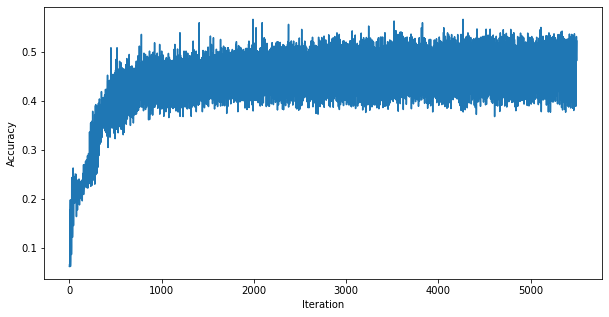

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

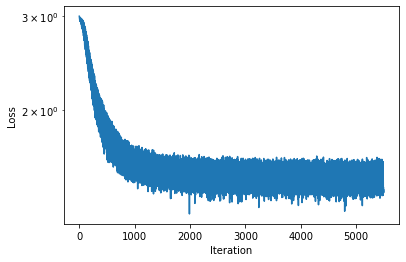

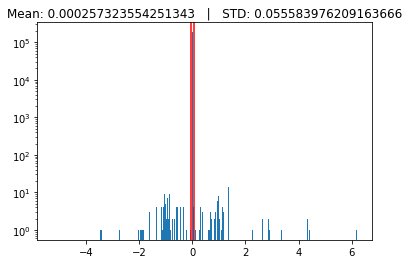

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.48062015503876


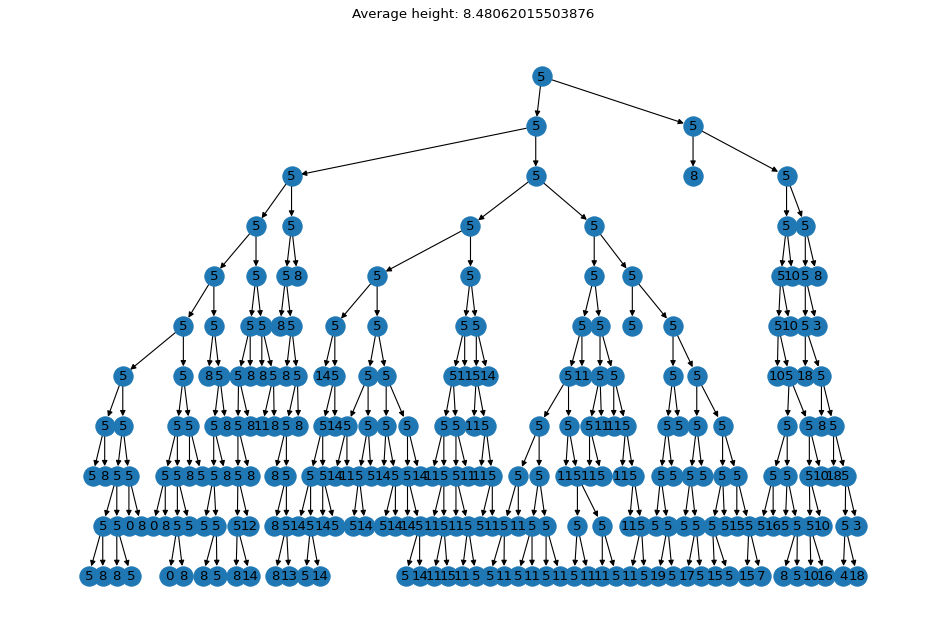

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 129


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

129
============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
2
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
78
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
4
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
==============

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 34 ==============
============== Pattern 35 ==============
============== Pattern 36 ==============
============== Pattern 37 ==============
============== Pattern 38 ==============
============== Pattern 39 ==============
============== Pattern 40 ==============
============== Pattern 41 ==============
============== Pattern 42 ==============
============== Pattern 43 ==============
============== Pattern 44 ==============
============== Pattern 45 ==============
============== Pattern 46 ==============
============== Pattern 47 ==============
============== Pattern 48 ==============
============== Pattern 49 ==============
============== Pattern 50 ==============
============== Pattern 51 ==============
============== Pattern 52 ==============
============== Pattern 53 ==============
============== Pattern 54 ==============
============== Pattern 55 ==============
============== Pattern 56 ==============
============== Pattern 57 ==============
============== P